This notebook shows an example of Support Vector Machine (SVM) applied to time series classification (accelerometer data). The task here is to classify 6 different types of activities (walking, walking upstairs, walking downstairs, sitting, standing, laying) based on x, y and z accelerometer signals. In this notebook we are going to extract features from raw signals and use this as input for the SVM. We optimize hyperparameters C and gamma to achieve the best f1-score on the test set.

## Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import preprocessing
from sklearn import svm
import plot_confusion_matrix as pcm
import matplotlib.pylab as plt
%matplotlib

Using matplotlib backend: MacOSX


## Loading data

We load the raw accelerometer signals of the 3 available axis (x, y and z). Each sample of the data set is a 2.56s window of an activity being performed recorded at a 50Hz rate which makes 128 readings per sample per axis.

In [2]:
os.chdir('data')
# Raw signals
# X axis
X_train_x_raw = np.loadtxt('X_x_train.txt')
X_test_x_raw = np.loadtxt('X_x_test.txt')
# Y axis
X_train_y_raw = np.loadtxt('X_y_train.txt')
X_test_y_raw = np.loadtxt('X_y_test.txt')
# Z axis
X_train_z_raw = np.loadtxt('X_z_train.txt')
X_test_z_raw = np.loadtxt('X_z_test.txt')

print("X_train_x_raw shape : {}".format(X_train_x_raw.shape))
print("X_test_x_raw shape : {}".format(X_test_x_raw.shape))
print("X_train_y_raw shape : {}".format(X_train_y_raw.shape))
print("X_test_y_raw shape : {}".format(X_test_y_raw.shape))
print("X_train_z_raw shape : {}".format(X_train_z_raw.shape))
print("X_test_z_raw shape : {}".format(X_test_z_raw.shape))

X_train_x_raw shape : (7352, 128)
X_test_x_raw shape : (2947, 128)
X_train_y_raw shape : (7352, 128)
X_test_y_raw shape : (2947, 128)
X_train_z_raw shape : (7352, 128)
X_test_z_raw shape : (2947, 128)


 We load the label vectors...

In [3]:
y_train = np.loadtxt('y_train.txt')
y_test = np.loadtxt('y_test.txt')

label_names = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']

print(y_train.shape)
print(y_test.shape)

(7352,)
(2947,)


## Feature extraction helper functions

As explained at the beginning of this notebook, we are not going to use the raw signals as input for our model but we are going to extract features from the signals. The following functions help us build the feature vectors out of the raw signals we have loaded above.
These functions help us extract statistical and geometrical features from raw signals and jerk signals (acceleration first derivative), frequency domain features from raw signals and jerk signals
For each sample we extract the following features:
  - **x,y and z raw signals** : mean, max, min, standard deviation, skewness, kurtosis, interquartile range, median absolute deviation, area under curve, area under squared curve
  - **x,y and z jerk signals (first derivative)** : mean, max, min, standard deviation, skewness, kurtosis, interquartile range, median absolute deviation, area under curve, area under squared curve
  - **x,y and z raw signals Discrete Fourrier Transform**: mean, max, min, standard deviation, skewness, kurtosis, interquartile range, median absolute deviation, area under curve, area under squared curve, weighted mean frequency, 5 first DFT coefficients, 5 first local maxima of DFT coefficients and their corresponding frequencies.
  - **x,y and z jerk signals Discrete Fourrier Transform**: mean, max, min, standard deviation, skewness, kurtosis, interquartile range, median absolute deviation, area under curve, area under squared curve, weighted mean frequency, 5 first DFT coefficients, 5 first local maxima of DFT coefficients and their corresponding frequencies.
  - **x,y and z correlation coefficients**

In [4]:
import scipy.stats as st
from scipy.fftpack import fft, fftfreq 
from scipy.signal import argrelextrema
import operator

def stat_area_features(x, Te=1.0):

    mean_ts = np.mean(x, axis=1).reshape(-1,1) # mean
    max_ts = np.amax(x, axis=1).reshape(-1,1) # max
    min_ts = np.amin(x, axis=1).reshape(-1,1) # min
    std_ts = np.std(x, axis=1).reshape(-1,1) # std
    skew_ts = st.skew(x, axis=1).reshape(-1,1) # skew
    kurtosis_ts = st.kurtosis(x, axis=1).reshape(-1,1) # kurtosis 
    iqr_ts = st.iqr(x, axis=1).reshape(-1,1) # interquartile rante
    mad_ts = np.median(np.sort(abs(x - np.median(x, axis=1).reshape(-1,1)),
                               axis=1), axis=1).reshape(-1,1) # median absolute deviation
    area_ts = np.trapz(x, axis=1, dx=Te).reshape(-1,1) # area under curve
    sq_area_ts = np.trapz(x ** 2, axis=1, dx=Te).reshape(-1,1) # area under curve ** 2

    return np.concatenate((mean_ts,max_ts,min_ts,std_ts,skew_ts,kurtosis_ts,
                           iqr_ts,mad_ts,area_ts,sq_area_ts), axis=1)

def frequency_domain_features(x, Te=1.0):

    # As the DFT coefficients and their corresponding frequencies are symetrical arrays
    # with respect to the middle of the array we need to know if the number of readings 
    # in x is even or odd to then split the arrays...
    if x.shape[1]%2 == 0:
        N = int(x.shape[1]/2)
    else:
        N = int(x.shape[1]/2) - 1
    xf = np.repeat(fftfreq(x.shape[1],d=Te)[:N].reshape(1,-1), x.shape[0], axis=0) # frequencies
    dft = np.abs(fft(x, axis=1))[:,:N] # DFT coefficients   
    
    # statistical and area features
    dft_features = stat_area_features(dft, Te=1.0)
    # weighted mean frequency
    dft_weighted_mean_f = np.average(xf, axis=1, weights=dft).reshape(-1,1)
    # 5 first DFT coefficients 
    dft_first_coef = dft[:,:5]    
    # 5 first local maxima of DFT coefficients and their corresponding frequencies
    dft_max_coef = np.zeros((x.shape[0],5))
    dft_max_coef_f = np.zeros((x.shape[0],5))
    for row in range(x.shape[0]):
        # finds all local maximas indexes
        extrema_ind = argrelextrema(dft[row,:], np.greater, axis=0) 
        # makes a list of tuples (DFT_i, f_i) of all the local maxima
        # and keeps the 5 biggest...
        extrema_row = sorted([(dft[row,:][j],xf[row,j]) for j in extrema_ind[0]],
                             key=operator.itemgetter(0), reverse=True)[:5] 
        for i, ext in enumerate(extrema_row):
            dft_max_coef[row,i] = ext[0]
            dft_max_coef_f[row,i] = ext[1]    
    
    return np.concatenate((dft_features,dft_weighted_mean_f,dft_first_coef,
                           dft_max_coef,dft_max_coef_f), axis=1)

def make_feature_vector(x,y,z, Te=1.0):

    # Raw signals :  stat and area features
    features_xt = stat_area_features(x, Te=Te)
    features_yt = stat_area_features(y, Te=Te)
    features_zt = stat_area_features(z, Te=Te)
    
    # Jerk signals :  stat and area features
    features_xt_jerk = stat_area_features((x[:,1:]-x[:,:-1])/Te, Te=Te)
    features_yt_jerk = stat_area_features((y[:,1:]-y[:,:-1])/Te, Te=Te)
    features_zt_jerk = stat_area_features((z[:,1:]-z[:,:-1])/Te, Te=Te) 
    
    # Raw signals : frequency domain features 
    features_xf = frequency_domain_features(x, Te=1/Te)
    features_yf = frequency_domain_features(y, Te=1/Te)
    features_zf = frequency_domain_features(z, Te=1/Te)
    
    # Jerk signals : frequency domain features 
    features_xf_jerk = frequency_domain_features((x[:,1:]-x[:,:-1])/Te, Te=1/Te)
    features_yf_jerk = frequency_domain_features((y[:,1:]-y[:,:-1])/Te, Te=1/Te)
    features_zf_jerk = frequency_domain_features((z[:,1:]-z[:,:-1])/Te, Te=1/Te)
    
    # Raw signals correlation coefficient between axis
    cor = np.empty((x.shape[0],3))
    for row in range(x.shape[0]):
        xyz_matrix = np.concatenate((x[row,:].reshape(1,-1),y[row,:].reshape(1,-1),
                                     z[row,:].reshape(1,-1)), axis=0)
        cor[row,0] = np.corrcoef(xyz_matrix)[0,1]
        cor[row,1] = np.corrcoef(xyz_matrix)[0,2]
        cor[row,2] = np.corrcoef(xyz_matrix)[1,2]
    
    return np.concatenate((features_xt, features_yt, features_zt,
                           features_xt_jerk, features_yt_jerk, features_zt_jerk,
                           features_xf, features_yf, features_zf,
                           features_xf_jerk, features_yf_jerk, features_zf_jerk,
                           cor), axis=1)

In [5]:
X_train = make_feature_vector(X_train_x_raw, X_train_y_raw, X_train_z_raw, Te=1/50)
X_test = make_feature_vector(X_test_x_raw, X_test_y_raw, X_test_z_raw, Te=1/50)

print("X_train shape : {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape : (7352, 219)
X_test shape: (2947, 219)


We scale the features (standard scaler i.e. each feature column has a zero mean and one standard deviation). 

In [6]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

## Building the SVM model

We are going to implement a SVM model with a RBF kernel. First we are going to build a grid search function to optimize the RBF kernel hyperparameters C and gamma to achieve the best f1 score on the test set.

In [7]:
def hyperparameters_opt_RBF(X_train, y_train, X_test, y_test,
                            param_range_C, param_range_gamma):

    accuracy_matrix = np.zeros((param_range_C.shape[0],param_range_gamma.shape[0]))
    for i,C in enumerate(param_range_C):
        for j,gamma in enumerate(param_range_gamma):
            clf_r_l = svm.SVC(kernel='rbf', C=C, gamma=gamma)
            clf_r_l.fit(X_train, y_train)
            accuracy_matrix[i,j] = f1_score(y_test ,clf_r_l.predict(X_test), average='macro')
    C_ind, gamma_ind = np.unravel_index(np.argmax(accuracy_matrix), accuracy_matrix.shape)

    return param_range_C[C_ind], param_range_gamma[gamma_ind]

In [8]:
# C and gamma test range
param_range = np.array([0.01, 0.1, 1, 10, 100, 1000])
# Optimizing C and gamma parameters to achieve the best f1 score 
C, gamma = hyperparameters_opt_RBF(X_train, y_train, X_test, y_test, param_range, param_range)

print("Hyperparameters optimization results:")
print("C: {}".format(C))
print("gamma: {}".format(gamma))
print("\n")

# Training the model with the optimized hyperparameters
clf_r_l = svm.SVC(kernel='rbf', C=C, gamma=gamma)
clf_r_l.fit(X_train, y_train)
y_pred_tr = clf_r_l.predict(X_train)
y_pred_te = clf_r_l.predict(X_test)

print('Training set report')
print(classification_report(y_train, y_pred_tr, target_names=label_names))
print('Test set report')
print(classification_report(y_test, y_pred_te, target_names=label_names))

plt.figure(1)
pcm.plot_confusion_matrix(confusion_matrix(y_train, y_pred_tr), label_names)
plt.figure(2)
pcm.plot_confusion_matrix(confusion_matrix(y_test, y_pred_te), label_names)
plt.show()

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Hyperparameters optimization results:
C: 1.0
gamma: 0.01


Training set report
                    precision    recall  f1-score   support

           Walking       1.00      1.00      1.00      1226
  Walking upstairs       1.00      1.00      1.00      1073
Walking downstairs       1.00      1.00      1.00       986
           Sitting       0.83      0.73      0.78      1286
          Standing       0.81      0.88      0.84      1374
            Laying       0.92      0.94      0.93      1407

       avg / total       0.92      0.92      0.92      7352

Test set report
                    precision    recall  f1-score   support

           Walking       0.94      0.98      0.96       496
  Walking upstairs       0.94      0.95      0.94       471
Walking downstairs       0.97      0.91      0.94       420
           Sitting       0.66      0.53      0.59       491
          Standing       0.68      0.83      0.75       532
            Laying       0.87      0.84      0.85       537



//anaconda/lib/python3.5/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


Confusion matrix

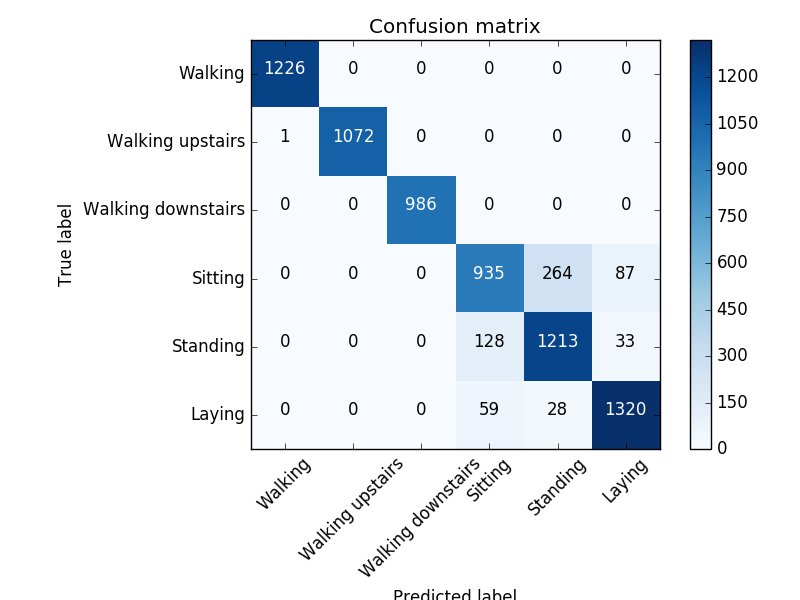

In [1]:
from IPython.display import Image
Image('images/svm_train.png')

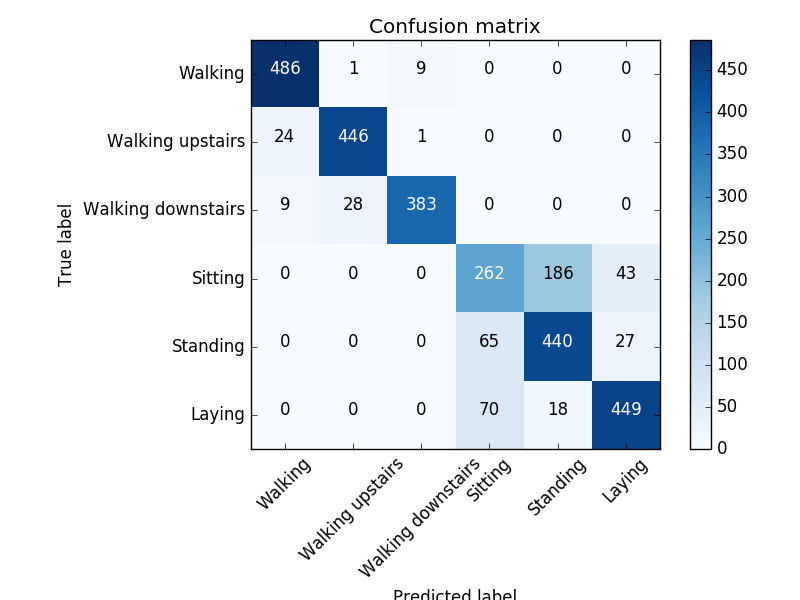

In [2]:
Image('images/svm_test.png')

### Comments

We achieve good results on the test set although there is a little confusion between "standing" and "sitting" as we can see in the prediction matrix above. We achieve similar results in the notebook where we build 2 layer neural network that we feed with the feature data ([here](https://github.com/jeandeducla/ML-Time-Series/blob/master/Neural_Network-Accelerometer-Features.ipynb)).